# Tutorial 5: Point-Neuron Network Models (with PointNet)

In this chapter we will create a heterogeneous network of point-model neurons and use the PointNet simulator which will run the network using the NEST simulator. As with the previous BioNet examples will create both a internal recurrently-connected network of different node types, and an external network of "virtual" neurons that will drive the firing of the internal neurons. And we'll show how to drive network activity by using a current clamp.

PointNet, like BioNet and the other simulators, use the SONATA data format for representing networks, setting up simulations and saving results. Thus the tools used to build and display biophysically detailed networks in the previous chapters will work just the same. 

Requirements:
* bmtk
* NEST 2.11+

## 1. Building the network

There are two ways of generating a network of point-neurons. Either we can take the existing biophysical network created in the previous chapters and make some minor adjustments to the neuron models being used. Or we can build a new network from scratch using the BMTK Builder.

### Converting networks
We want to take the BioNet V1 network and change parameters so that the individual neurons are using point models. Luckily there parameters are stored in the node and edge "types" csv files, thus we can easily change them with a simple text editor (emacs, vi, sublime-text, etc). Here is an example of the old *V1_node_types.csv*: 

In [1]:
import pandas as pd

pd.read_csv('sources/chapter05/converted_network/V1_node_types_bionet.csv', sep=' ')

,node_type_id,ei,morphology_file,model_processing,pop_name,location,model_template,model_type,dynamics_params
0,100,e,Scnn1a.swc,aibs_perisomatic,Scnn1a,L4,ctdb:Biophys1.hoc,biophysical,472363762_fit.json
1,101,i,Pvalb.swc,aibs_perisomatic,PV,L4,ctdb:Biophys1.hoc,biophysical,472912177_fit.json
2,102,e,NaN,NaN,LIF_exc,VisL4,nrn:IntFire1,point_process,IntFire1_exc_1.json
3,103,i,NaN,NaN,LIF_inh,VisL4,nrn:IntFire1,point_process,IntFire1_inh_1.json


and here is the *V1_node_types.csv* used for PointNet:

In [2]:
pd.read_csv('sources/chapter05/converted_network/V1_node_types.csv', sep=' ')

,node_type_id,ei,morphology_file,model_processing,pop_name,location,model_template,model_type,dynamics_params
0,100,e,NaN,NaN,Scnn1a,L4,nest:iaf_psc_alpha,point_process,472363762_point.json
1,101,i,NaN,NaN,PV,L4,nest:iaf_psc_alpha,point_process,472912177_point.json
2,102,e,NaN,NaN,LIF_exc,VisL4,nest:iaf_psc_alpha,point_process,IntFire1_exc_point.json
3,103,i,NaN,NaN,LIF_inh,VisL4,nest:iaf_psc_alpha,point_process,IntFire1_inh_point.json


Changes:
* **model_type** - PointNet will not support the "biophysical" model_type and only support "point_process" neuron models.
* **model_template** - nrn:IntFire1 and ctdb:Biophys1.hoc are special directives for running NEURON based models. Instead we replaced them with the "nest:\<nest-model\>" directive (note we can replace iaf_psc_alpha with any valid NEST model).
* **dynamics_params** - We have new json parameters files for the new NEST based models.
* **model_processing** - "aibs_perisomatic" is a special command for adjusting the morphology of biophysical models, and since our NEST-based models do not have a morphology we set it to none which tells the simulator to use the models as-is (note: you can implement custom model_processing functions for PointNet that will be explained later).

We must also adjust the *edges_types.csv* files:

In [3]:
pd.read_csv('sources/chapter05/converted_network/V1_V1_edge_types.csv', sep=' ')

,edge_type_id,target_query,source_query,syn_weight,dynamics_params,distance_range,delay,target_sections,weight_function,model_template,weight_sigma
0,100,pop_name=='Scnn1a',ei=='e',50.00000,ExcToExc.json,NaN,2.0,NaN,gaussianLL,static_synapse,50.0
1,101,pop_name=='LIF_exc',ei=='e',50.00000,instanteneousExc.json,NaN,2.0,NaN,gaussianLL,static_synapse,50.0
2,102,model_type=='biophysical'&ei=='i',ei=='i',50.00000,InhToInh.json,NaN,2.0,NaN,wmax,static_synapse,NaN
3,103,model_type=='point_process'&ei=='i',ei=='i',50.00000,instanteneousInh.json,NaN,2.0,NaN,wmax,static_synapse,NaN
4,104,model_type=='biophysical'&ei=='e',ei=='i',50.00000,InhToExc.json,NaN,2.0,NaN,wmax,static_synapse,NaN
5,105,model_type=='point_process'&ei=='e',ei=='i',30.00000,instanteneousInh.json,NaN,2.0,NaN,wmax,static_synapse,NaN
6,106,pop_name=='PV',ei=='e',0.00035,ExcToInh.json,NaN,2.0,NaN,wmax,static_synapse,NaN
7,107,pop_name=='LIF_inh',ei=='e',50.00000,instanteneousExc.json,NaN,2.0,NaN,wmax,static_synapse,NaN


* **model_template** has been changed to use a NEST based model type (static_synapse)
* Use different **dynamics_parameter** files 
* It's important to readjust **syn_weight** as values appropiate for NEURON based models are oftern wrong for NEST based models. 

Notice we don't have to change any of the hdf5 files. The network topology remains the same making it a powerful tool for comparing networks of different levels of resolution.

### Building a model from scratch.

We can use the BMTK Network Builder to create new network files just for point-based modeling

#### V1 Network

First lets build a "V1" network of 300 cells, split into 4 different populations 

In [4]:
from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_columinar

net = NetworkBuilder("V1")
net.add_nodes(N=80,  # Create a population of 80 neurons
              positions=positions_columinar(N=80, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
              pop_name='Scnn1a', location='VisL4', ei='e',  # optional parameters
              model_type='point_process',  # Tells the simulator to use point-based neurons
              model_template='nest:iaf_psc_alpha',  # tells the simulator to use NEST iaf_psc_alpha models
              dynamics_params='472363762_point.json'  # File containing iaf_psc_alpha mdoel parameters
             )

net.add_nodes(N=20, pop_name='PV', location='VisL4', ei='i',
              positions=positions_columinar(N=20, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
              model_type='point_process',
              model_template='nest:iaf_psc_alpha',
              dynamics_params='472912177_point.json')

net.add_nodes(N=200, pop_name='LIF_exc', location='L4', ei='e',
              positions=positions_columinar(N=200, center=[0, 50.0, 0], min_radius=30.0, max_radius=60.0, height=100.0),
              model_type='point_process',
              model_template='nest:iaf_psc_alpha',
              dynamics_params='IntFire1_exc_point.json')

net.add_nodes(N=100, pop_name='LIF_inh', location='L4', ei='i',
              positions=positions_columinar(N=100, center=[0, 50.0, 0], min_radius=30.0, max_radius=60.0, height=100.0),
              model_type='point_process',
              model_template='nest:iaf_psc_alpha',
              dynamics_params='IntFire1_inh_point.json')

We can now go ahead and created synaptic connections then build and save our network.

In [5]:
from bmtk.builder.auxi.edge_connectors import distance_connector

## E-to-E connections
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'Scnn1a'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=3.0,
              delay=2.0,
              dynamics_params='ExcToExc.json',
              model_template='static_synapse')

net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_exc'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=3.0,
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='static_synapse')


### Generating I-to-I connections
net.add_edges(source={'ei': 'i'}, target={'pop_name': 'PV'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=-3.0,
              delay=2.0,
              dynamics_params='InhToInh.json',
              model_template='static_synapse')

net.add_edges(source={'ei': 'i'}, target={'ei': 'i', 'pop_name': 'LIF_inh'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=-3.0,
              delay=2.0,
              dynamics_params='instanteneousInh.json',
              model_template='static_synapse')

### Generating I-to-E connections
net.add_edges(source={'ei': 'i'}, target={'ei': 'e', 'pop_name': 'Scnn1a'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=-3.0,
              delay=2.0,
              dynamics_params='InhToExc.json',
              model_template='static_synapse')

net.add_edges(source={'ei': 'i'}, target={'ei': 'e', 'pop_name': 'LIF_exc'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=-3.0,
              delay=2.0,
              dynamics_params='instanteneousInh.json',
              model_template='static_synapse')

### Generating E-to-I connections
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'PV'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.26, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=3.0,
              delay=2.0,
              dynamics_params='ExcToInh.json',
              model_template='static_synapse')


net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_inh'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.26, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=3.0,
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='static_synapse')

In [6]:
net.build()
net.save_nodes(output_dir='sim_ch05/network')
net.save_edges(output_dir='sim_ch05/network')

### Building external network

Next we want to create an external network of "virtual cells" with spike-trains that will synapse onto our V1 cells and drive activity. We will call this external network "LGN" and contains 500 excitatory cells.

In [7]:
lgn = NetworkBuilder('LGN')
lgn.add_nodes(N=500, pop_name='tON', potential='exc', model_type='virtual')


We will use a special function for setting the number of synapses between the LGN --> V1 cells. The select_source_cells function will be called during the build process.

In [8]:
import numpy as np

def select_source_cells(sources, target, nsources_min=10, nsources_max=30, nsyns_min=3, nsyns_max=12):
    total_sources = len(sources)
    nsources = np.random.randint(nsources_min, nsources_max)
    selected_sources = np.random.choice(total_sources, nsources, replace=False)
    syns = np.zeros(total_sources)
    syns[selected_sources] = np.random.randint(nsyns_min, nsyns_max, size=nsources)
    return syns

lgn.add_edges(source=lgn.nodes(), target=net.nodes(pop_name='Scnn1a'),
              iterator='all_to_one',
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 10, 'nsources_max': 25},
              syn_weight=15.0,
              delay=2.0,
              dynamics_params='ExcToExc.json',
              model_template='static_synapse')

lgn.add_edges(source=lgn.nodes(), target=net.nodes(pop_name='PV1'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 15, 'nsources_max': 30},
              iterator='all_to_one',
              syn_weight=5.0,
              delay=2.0,
              dynamics_params='ExcToInh.json',
              model_template='static_synapse')

lgn.add_edges(source=lgn.nodes(),  target=net.nodes(pop_name='LIF_exc'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 10, 'nsources_max': 25},
              iterator='all_to_one',
              syn_weight= 10.0,
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='static_synapse')

lgn.add_edges(source=lgn.nodes(),  target=net.nodes(pop_name='LIF_inh'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 15, 'nsources_max': 30},
              iterator='all_to_one',
              syn_weight=10.0,
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='static_synapse')

Finally we build and save our lgn network.

In [9]:
lgn.build()
lgn.save_nodes(output_dir='sim_ch05/network')
lgn.save_edges(output_dir='sim_ch05/network')

## 2. Setting up PointNet Environment

### Directory Structure

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. If using the tutorial these files will already be in place. Otherwise we can use a command-line:
```bash
$ python -m bmtk.utils.sim_setup        \
    --network sim_ch05/network/         \
    --include-examples                  \
    --tstop 3000.0                      \
    pointnet sim_ch05/

```

or

In [10]:
from bmtk.utils.sim_setup import build_env_pointnet

build_env_pointnet(base_dir='sim_ch05',      
                   network_dir='sim_ch05/network',
                   tstop=3000.0, 
                   dt=0.01,
                   include_examples=True,         # Copies components files
                  )

The network files are written to **circuit_config.json** and the simulation parameters are set in **simulation_config**. The simulation time is set to run for 3000.0 ms (tstop). We also specify a membrane-report to record V_m property of 4 cells (gids 0, 80, 100, 300 - one from each cell-type). In general, all the parameters needed to setup and start a simulation are found in the config files, and adjusting network/simulation conditions can be done by editing these json files in a text editor.

#### lgn input

We need to provide our LGN external network cells with spike-trains so they can activate our recurrent network. Previously we showed how to do this by generating csv files. We can also use NWB files, which are a common format for saving electrophysiological data in neuroscience.

We can use any NWB file generated experimentally or computationally, but for this example we will use a preexsting one. First download the file:
```bash
 $ cd sim_ch05
 $ wget https://github.com/AllenInstitute/bmtk/raw/develop/docs/examples/spikes_inputs/lgn_spikes.h5
```
Then we must edit the simulation_config.json file to tell the simulator to find the nwb file and which network to associate it with.

```json
{
  "inputs": {
    "LGN_spikes": {
      "input_type": "spikes",
      "module": "h5",
      "input_file": "$BASE_DIR/lgn_spikes.h5",
      "node_set": "LGN"
    }
  }
}
```


## 3. Running the simulation

The call to sim_setup created a file run_pointnet.py which we can run directly in a command line:
```bash
$ python run_pointnet.py config.json
```
or if you have mpi setup:

```bash
$ mpirun -np $NCORES python run_pointnet.py config.json
```

Or we can run it directly

In [11]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('sim_ch05/simulation_config.json')
configure.build_env()
network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2020-08-25 15:34:08,266 [INFO] Created log file
2020-08-25 15:34:08,307 [INFO] Batch processing nodes for LGN/0.
2020-08-25 15:34:08,361 [INFO] Batch processing nodes for V1/0.
2020-08-25 15:34:08,449 [INFO] Setting up output directory
2020-08-25 15:34:08,450 [INFO] Building cells.
2020-08-25 15:34:08,495 [INFO] Building recurrent connections
2020-08-25 15:34:08,628 [INFO] Build virtual cell stimulations for LGN_spikes
2020-08-25 15:34:53,999 [INFO] Network created.
2020-08-25 15:34:54,463 [INFO] Starting Simulation
2020-08-25 15:35:01,445 [INFO] Simulation finished, finalizing results.
2020-08-25 15:35:02,240 [INFO] Done.


## 4. Analyzing results

Results of the simulation, as specified in the config, are saved into the output directory. Using the analyzer functions, we can do things like plot the raster plot

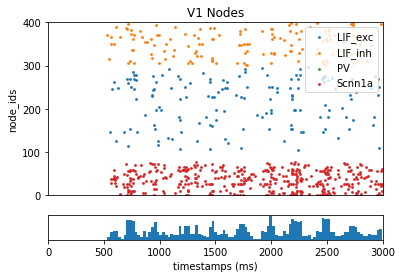

In [13]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates

plot_raster(config_file='sim_ch05/simulation_config.json', group_by='pop_name')

Or we can plot the rates of the different populations

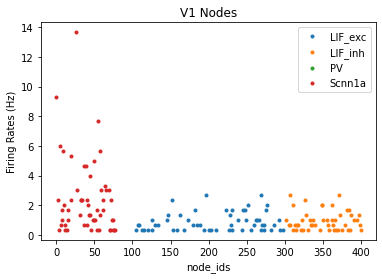

In [14]:
plot_rates(config_file='sim_ch05/simulation_config.json', group_by='pop_name')

In our simulation_config.json in the reports section, we can see we also record the V_m (i.e membrane potential) of a select sample of cells. By default these files are written to an hdf5 file with the same name as the report (membrane_potential.h5), and we can use the analyzer to show the time course of some of these cells.

## 5. Additional Information

### Recording membrane potential  (and other cell properties).

By default bmtk will automatically record and save the spike-trains of our (non-virtual) cells. Sometimes it can be useful to record other properties besides spikes, like the membrane voltage traces, of all or a subsection of the cells. To do so we only need to open the _simulation_config.json_ with our prefered text editor and insert the following section:

```json
{
  "reports": {
    "membrane_potential": {
      "cells": {
        "population": "V1", 
        "node_id": [0, 20, 60, 80, 100]
      },
      "variable_name": "V_m",
      "module": "multimeter_report",
      "sections": "soma"
    }
  }
}
```

This will tell bmtk to record the "V_m" variable for selected cells with ids 0, 20, 60, 80, 100 - and save the results in a file _output/membrane_potential.h5_. After re-running the simulation the file will be generated, [according to the SONATA format](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#frame-oriented-node-element-recordings), which we can read using hdf5 or bmtk like below:

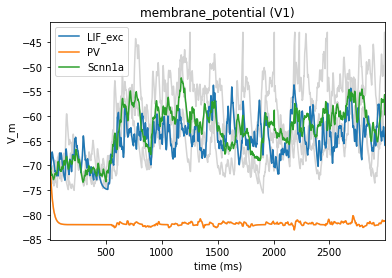

In [16]:
from bmtk.analyzer.compartment import plot_traces

_ = plot_traces(config_file='sim_ch05/simulation_config.json', group_by='pop_name')

### Perturbation simulations

A common use case is to mimick a network where the firing rate of select cells are being depressed or stimulated using current clamps or optogenetic methods. The best way to do this is by applying a current clamp in a similar manner used in [bionet](http://localhost:32000/notebooks/Workspace/bmtk/docs/tutorial/01_single_cell_clamped.ipynb).

The point_120cells network in the bmtk examples consists of 120 recurrently connected excitatory and inhibitory cells with randomized inputs. Normally the results without any type of perturbations will look as follows:
<img src="_static/_tutorial_images/raster_120cells_orig.png">

To artifically excite some of the cells we can open the config.json file and add the following section to the "inputs":
```json
{
  "exc_perturbation": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
      "population": "cortex",
      "node_ids": [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
    },
    "amp": 230.0,
    "delay": 1.0,
    "duration": 3000.0
  }
}
```

This will apply a large step current for the duration of the simulation for cells 20 through 39. In this case we knew the exact node_ids of the cells we want to excite. However it is also possible to get a subset using a specific property, for example if we wanted to only select inhibitory L2/3 cells:
```json
{
  "node_set": {
    "population": "cortex",
    "ei": "i",
    "location": "L2/3"
  }
}
```

To simulate depression of cells 40 to 49 we will add another current_clamp but with a large negative current:
```json
{
  "inh_perturbation": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
      "population": "cortex",
      "node_ids": [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    },
    "amp": -230.0,
    "delay": 1.0,
    "duration": 3000.0
  }
}
```

After we rerun the simulation:
<img src="_static/_tutorial_images/raster_120cells_perturbed.png">


